This code is pretty undocumented and based on work here: https://ajolicoeur.wordpress.com/relativisticgan/

In [1]:
%pylab inline

from functools import partial

import keras
import keras_contrib
import keras.backend as K
import tensorflow as tf

import matplotlib.pyplot as plt

import sys

import numpy as np

import glob
import imageio
import lycon
from skimage import transform
from tqdm import tqdm as old_tqdm
from tqdm import tqdm_notebook as tqdm

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
RANDOM_SEED = 1
IMG_SIZE = 64 # should be power of two and square
CHANNELS = 3
N_CRITIC = 1
N_GEN = 1
LR = 0.0002
BATCH_SIZE = 32
N_EPOCHS = 10
BETAS = (0.5, 0.999)
LOSS = "RaLSGAN" # one of RGAN, RaGAN, LSGAN, RaLSGAN, HingeGAN, RaHingeGAN

In [3]:
random.seed(RANDOM_SEED)
numpy.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)

img_shape = [IMG_SIZE, IMG_SIZE, CHANNELS]

latent_dim = 100

# Following parameter and optimizer set as recommended in paper
n_critic = 1
n_gen = 1
lr = 0.0002
optimizer = keras.optimizers.Adam(lr=LR, beta_1=BETAS[0], beta_2=BETAS[1])
tnorm = keras.initializers.truncated_normal(stddev=.02)
rnorm = keras.initializers.random_normal(stddev=.02)
lrelu = lambda x: keras.activations.relu(x, alpha=.2)

In [4]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=2 / 255)

train_data = datagen.flow_from_directory(
    target_size=img_shape[:2],
    directory = "/home/ubuntu/downloads/img_align_celeba",
    batch_size=BATCH_SIZE)

Found 202599 images belonging to 1 classes.


In [5]:
start_pow = np.log2(IMG_SIZE) - 3

In [6]:
##################
#
# Build Generator
#
#################


dim = 64
k = 4
DROP = 0.00

noise = keras.Input(shape=(latent_dim, ))

noise_block = keras.layers.Dense(
    int(dim * (2**start_pow)) * 4 * 4,
    activation="relu",
    input_dim=latent_dim,
    kernel_initializer=rnorm)(noise)
noise_block = keras.layers.BatchNormalization()(noise_block)
noise_block = keras.layers.Reshape((4, 4, int(dim * (2**start_pow))))(noise_block)
noise_block = keras.layers.Dropout(DROP)(noise_block)

conv_block = noise_block

n_blocks = int(start_pow + 1)
curr_dim = int((2**(start_pow-1)) * dim)

for i in range(n_blocks):
    
    if curr_dim >= dim:
        conv_block = keras.layers.Conv2DTranspose(
            curr_dim,
            kernel_size=k,
            strides=2,
            padding="same",
            activation=lrelu,
            kernel_initializer=rnorm,
            use_bias=False)(conv_block)
        curr_dim = curr_dim // 2
        conv_block = keras.layers.BatchNormalization()(conv_block)
        conv_block = keras.layers.Dropout(DROP)(conv_block)
        
    else:
        conv_block = keras.layers.Conv2DTranspose(
            CHANNELS,
            kernel_size=k,
            strides=2,
            padding="same",
            activation="tanh",
            kernel_initializer=rnorm,
            use_bias=False)(conv_block)
        
    

img = conv_block

generator = keras.Model(noise, img)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8192)              32768     
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         2097152   
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1024      
__________

In [7]:
import tensorflow as tf

def ln_func(x):
    return tf.contrib.layers.layer_norm(x)

layer_norm = lambda : keras.layers.Lambda(ln_func)

In [8]:
##################
#
# Build Critic
#
#################

dim = 64
k = 4
DROP = 0.0

img = keras.Input(shape=img_shape)

conv_block = img

# conv_block = keras.layers.GaussianNoise(2/255)(conv_block)

for i in range(n_blocks):
    conv_block = keras.layers.Conv2D(
        dim * (2**i),
        kernel_size=k,
        strides=2,
        padding="same",
        activation=lrelu,
        kernel_initializer=tnorm,
        use_bias=False,
    )(conv_block)
    conv_block = layer_norm()(conv_block)
#     conv_block = keras.layers.BatchNormalization()(conv_block)
    conv_block = keras.layers.Dropout(DROP)(conv_block)

conv_block = keras.layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    kernel_initializer=tnorm,
    use_bias=False,
)(conv_block)

class_block = keras.layers.Flatten()(conv_block)

critic = keras.Model(img, class_block)

critic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        3072      
_________________________________________________________________
lambda_1 (Lambda)            (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       131072    
_________________________________________________________________
lambda_2 (Lambda)            (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 128)       0         
__________

In [9]:
def noop_loss(target, output):
    return output

def BCE(logits, labels):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits =logits, labels=labels)

### Relativistic Standard GAN

# No sigmoid activation in last layer of generator because BCEWithLogitsLoss() already adds it

# BCE_stable = torch.nn.BCEWithLogitsLoss()

# # Discriminator loss
# errD = BCE_stable(y_pred - y_pred_fake, y)
# errD.backward()

# # Generator loss (You may want to resample again from real and fake data)
# errG = BCE_stable(y_pred_fake - y_pred, y)
# errG.backward()

def rgan_loss(inputs):
    
    y_pred = inputs[0]
    y_pred_fake = inputs[1]
    y = K.ones_like(y_pred)
    
    return BCE(y_pred - y_pred_fake, y)


### Relativistic average Standard GAN

# No sigmoid activation in last layer of generator because BCEWithLogitsLoss() already adds it

# BCE_stable = torch.nn.BCEWithLogitsLoss()

# # Discriminator loss
# errD = ((BCE_stable(y_pred - torch.mean(y_pred_fake), y) + BCE_stable(y_pred_fake - torch.mean(y_pred), y2))/2
# errD.backward()

# # Generator loss (You may want to resample again from real and fake data)
# errG = ((BCE_stable(y_pred - torch.mean(y_pred_fake), y2) + BCE_stable(y_pred_fake - torch.mean(y_pred), y))/2
# errG.backward()

def ragan_loss(inputs):
    
    y_pred = inputs[0]
    y_pred_fake = inputs[1]
    y = K.ones_like(y_pred)
    y2 = K.zeros_like(y_pred)
        
    first_term = BCE(y_pred - K.mean(y_pred_fake), y)
    second_term = BCE(y_pred_fake - K.mean(y_pred), y2)
        
    return (first_term + second_term)/2

### Relativistic average LSGAN

# No activation in generator

# Discriminator loss
# errD = (torch.mean((y_pred - torch.mean(y_pred_fake) - y) ** 2) + torch.mean((y_pred_fake - torch.mean(y_pred) + y) ** 2))/2
# errD.backward()

# # Generator loss (You may want to resample again from real and fake data)
# errG = (torch.mean((y_pred - torch.mean(y_pred_fake) + y) ** 2) + torch.mean((y_pred_fake - torch.mean(y_pred) - y) ** 2))/2
# errG.backward()

def ralsgan_loss(inputs):
    
    y_pred = inputs[0]
    y_pred_fake = inputs[1]
    
    y = K.ones_like(y_pred)
    
    first_term = K.mean((y_pred - K.mean(y_pred_fake) - y)**2)
    second_term = K.mean((y_pred_fake - K.mean(y_pred) +y)**2)
    
    return (first_term + second_term)/2

### Relativistic average HingeGAN

# No activation in generator

# # Discriminator loss
# errD = (torch.mean(torch.nn.ReLU()(1.0 - (y_pred - torch.mean(y_pred_fake)))) + torch.mean(torch.nn.ReLU()(1.0 + (y_pred_fake - torch.mean(y_pred)))))/2
# errD.backward()
 
# # Generator loss  (You may want to resample again from real and fake data)
# errG = (torch.mean(torch.nn.ReLU()(1.0 + (y_pred - torch.mean(y_pred_fake)))) + torch.mean(torch.nn.ReLU()(1.0 - (y_pred_fake - torch.mean(y_pred)))))/2
# errG.backward()

def rahingegan_loss(inputs):
    
    y_pred = inputs[0]
    y_pred_fake = inputs[1]
    
    y = K.ones_like(y_pred)
    
    first_term = K.relu(1.0 - (y_pred - K.mean(y_pred_fake)))
    second_term = K.relu(1.0 + (y_pred_fake - K.mean(y_pred)))
    
    return (first_term + second_term)/2

gan_loss = {
    "RGAN": rgan_loss, 
    "RaGAN": ragan_loss, 
    "RaLSGAN": ralsgan_loss, 
    "RaHingeGAN": rahingegan_loss
}[LOSS]

In [10]:
#-------------------------------
#       Set up tensors for 
#       computational graph
#-------------------------------

# Image input (real sample)
real_img = keras.Input(shape=img_shape)

# Noise input
z_disc = keras.Input(shape=(latent_dim, ))
# Generate image based of noise (fake sample)
fake_img = generator(z_disc)

# Discriminator determines validity of the real and fake images
y_pred_fake = critic(fake_img)
y_pred = critic(real_img)

In [11]:
#-------------------------------
# Construct Computational Graph
#       for the Critic
#-------------------------------

# Freeze generator's layers while training critic
critic.trainable = True
generator.trainable = False

critic_loss = keras.layers.Lambda(gan_loss)([y_pred, y_pred_fake])

critic_model = keras.Model(inputs=[real_img, z_disc], outputs=[critic_loss])
critic_model.compile(loss=[noop_loss], optimizer=optimizer)

In [12]:
#-------------------------------
# Construct Computational Graph
#         for Generator
#-------------------------------

# For the generator we freeze the critic's layers
critic.trainable = False
generator.trainable = True

gen_loss = keras.layers.Lambda(gan_loss)([y_pred_fake, y_pred])

gen_model = keras.Model(inputs=[real_img, z_disc], outputs=[gen_loss])
gen_model.compile(loss=[noop_loss], optimizer=optimizer)

In [13]:
imgs, _ = train_data.next()
imgs.min(), imgs.max()

(0.0, 2.0)

In [14]:
import shutil, os

n_critic = 1
n_gen = 1

def train(steps, batch_size, sample_interval=50, hist_interval=1000):
    
    d_loss_list = []
    g_loss_list = []

    shutil.rmtree("celeba_images", ignore_errors=True)
    os.makedirs("celeba_images", exist_ok=True)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    for step in old_tqdm(range(1,steps+1)):

        for _ in range(n_critic):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            
            imgs = train_data.next()[0] - 1
            
            # Sample generator input
            noise = np.random.normal(0, 1, (imgs.shape[0], latent_dim))
            # Train the critic
            d_loss = critic_model.train_on_batch([imgs, noise], np.ones((imgs.shape[0], 1)))
            d_loss_list.append(d_loss)
        
        for _ in range(n_gen):
            
            # ---------------------
            #  Train Generator
            # ---------------------
            
            # Select a random batch of images
            imgs = train_data.next()[0] - 1
            # Sample generator input
            noise = np.random.normal(0, 1, (imgs.shape[0], latent_dim))

            g_loss = gen_model.train_on_batch([imgs, noise], np.ones((imgs.shape[0], 1)))
            g_loss_list.append(g_loss)
        

        # If at save interval => save generated image samples
        if step % sample_interval == 0:
            print_string = f"step: {step}, D: {d_loss:g}, G: {g_loss:g}"
            print(print_string)
            sample_images(print_string, step)
            
        if step % hist_interval == 0:
            plot(range(1,step+1),d_loss_list, label="critic loss")
            plot(range(1,step+1),g_loss_list, label="generator loss")
            plt.legend()
            plt.savefig("history.png")
            plt.show()

def sample_images(print_string, step):
    # make a video with 
    # >ffmpeg -y -framerate 4 -pattern_type glob -i 'im_*.png' -pix_fmt yuv420p -vf scale=500:-1 output.mp4
    
    
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + .5

    fig, axs = plt.subplots(r, c, sharex=True, sharey=True, frameon=False, figsize=(5,5))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,...], aspect="auto", interpolation="spline16")
            axs[i,j].axis('off')
            cnt += 1
    plt.tight_layout(h_pad=0, w_pad=0)
    plt.suptitle(print_string, backgroundcolor="white", fontsize=7)
    fig.savefig(f"celeba_images/im_{step:05d}.png", dpi=150)
    plt.close()

In [15]:
steps_per_epoch = train_data.n//(train_data.batch_size*2)
total_steps = N_EPOCHS*steps_per_epoch

  0%|          | 0/31650 [00:00<?, ?it/s]/home/ubuntu/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  0%|          | 99/31650 [00:27<2:27:53,  3.56it/s]

step: 100, D: 0.931119, G: 2.22551


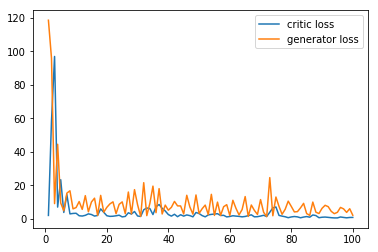

  1%|          | 199/31650 [00:49<2:10:50,  4.01it/s]

step: 200, D: 0.238962, G: 4.94315


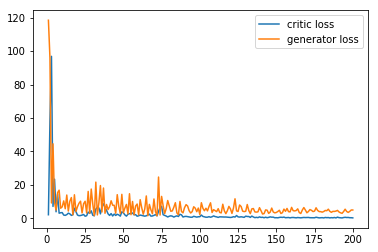

  1%|          | 299/31650 [01:11<2:04:21,  4.20it/s]

step: 300, D: 0.223133, G: 3.64884


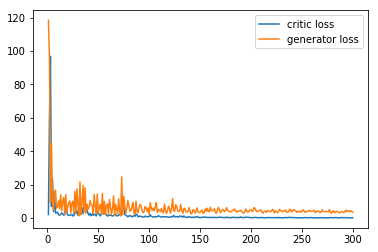

  1%|▏         | 399/31650 [01:32<2:01:01,  4.30it/s]

step: 400, D: 0.145302, G: 3.56603


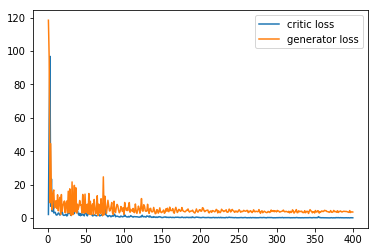

  2%|▏         | 499/31650 [01:54<1:59:19,  4.35it/s]

step: 500, D: 0.171313, G: 3.01758


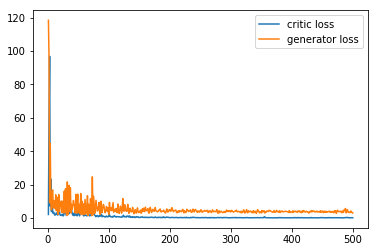

  2%|▏         | 599/31650 [02:16<1:57:43,  4.40it/s]

step: 600, D: 0.192673, G: 3.21689


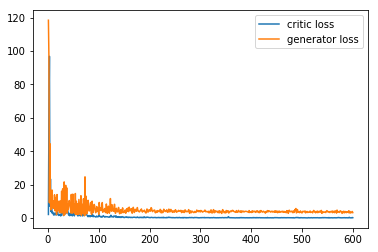

  2%|▏         | 699/31650 [02:37<1:56:27,  4.43it/s]

step: 700, D: 0.13769, G: 3.77123


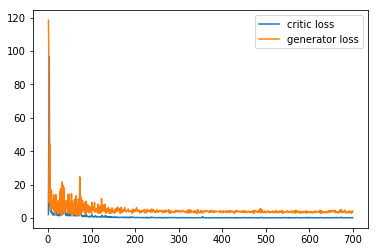

  3%|▎         | 799/31650 [02:59<1:55:26,  4.45it/s]

step: 800, D: 0.125568, G: 3.8482


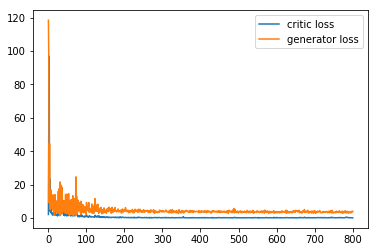

  3%|▎         | 899/31650 [03:21<1:54:37,  4.47it/s]

step: 900, D: 0.255234, G: 4.61687


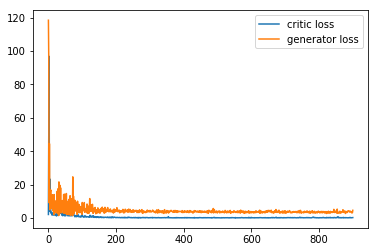

  3%|▎         | 999/31650 [03:42<1:53:45,  4.49it/s]

step: 1000, D: 0.293, G: 4.61814


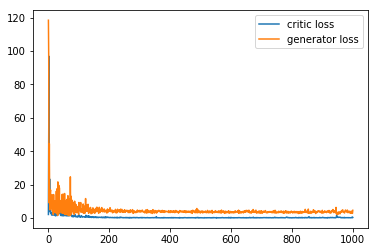

  3%|▎         | 1099/31650 [04:03<1:52:57,  4.51it/s]

step: 1100, D: 0.307524, G: 3.83076


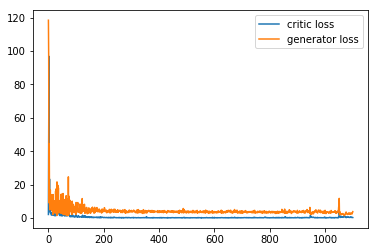

  4%|▍         | 1199/31650 [04:25<1:52:11,  4.52it/s]

step: 1200, D: 0.438266, G: 3.35346


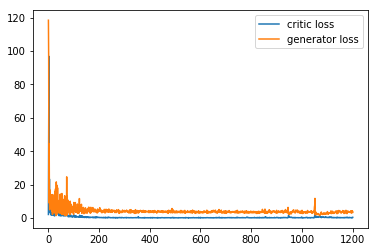

  4%|▍         | 1299/31650 [04:46<1:51:34,  4.53it/s]

step: 1300, D: 0.220995, G: 3.04101


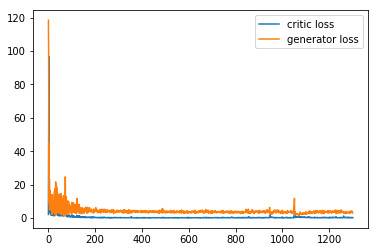

  4%|▍         | 1399/31650 [05:07<1:50:57,  4.54it/s]

step: 1400, D: 0.234295, G: 4.65863


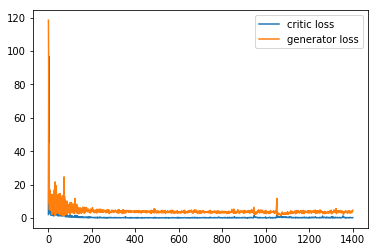

  5%|▍         | 1499/31650 [05:29<1:50:24,  4.55it/s]

step: 1500, D: 0.253337, G: 3.13165


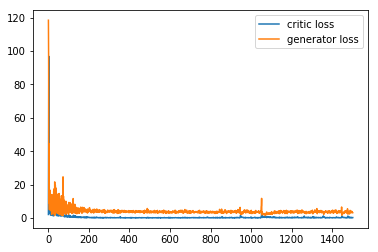

  5%|▌         | 1599/31650 [05:50<1:49:49,  4.56it/s]

step: 1600, D: 0.423615, G: 2.75281


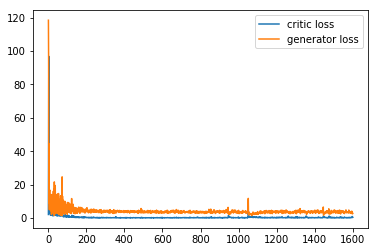

  5%|▌         | 1699/31650 [06:12<1:49:22,  4.56it/s]

step: 1700, D: 0.210536, G: 5.42647


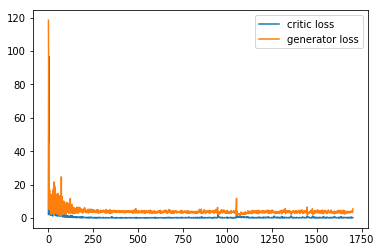

  6%|▌         | 1799/31650 [06:33<1:48:51,  4.57it/s]

step: 1800, D: 0.314328, G: 3.41284


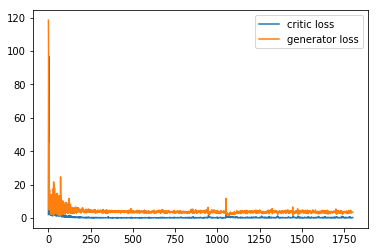

  6%|▌         | 1899/31650 [06:55<1:48:22,  4.58it/s]

step: 1900, D: 0.259676, G: 3.18692


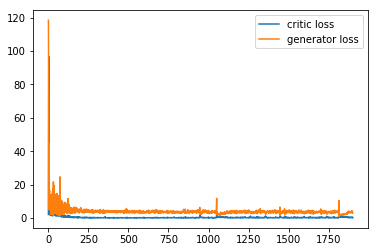

  6%|▋         | 1999/31650 [07:16<1:47:52,  4.58it/s]

step: 2000, D: 0.301503, G: 3.73105


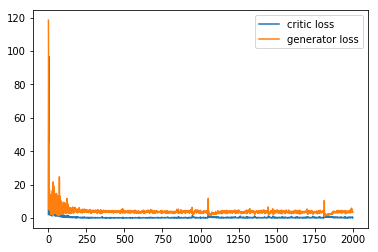

  7%|▋         | 2099/31650 [07:37<1:47:27,  4.58it/s]

step: 2100, D: 0.185884, G: 3.62626


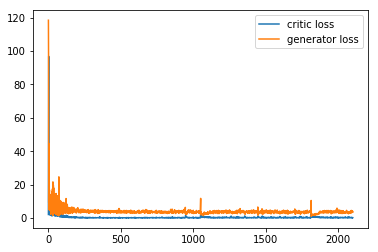

  7%|▋         | 2199/31650 [07:59<1:47:01,  4.59it/s]

step: 2200, D: 0.297809, G: 2.97733


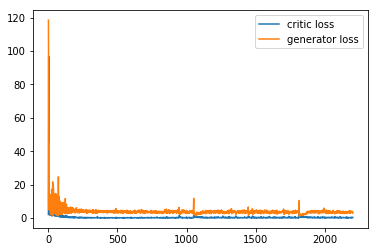

  7%|▋         | 2299/31650 [08:20<1:46:33,  4.59it/s]

step: 2300, D: 0.185983, G: 3.34518


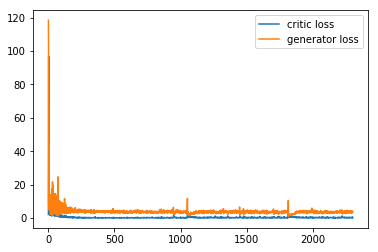

  8%|▊         | 2399/31650 [08:42<1:46:08,  4.59it/s]

step: 2400, D: 0.226118, G: 3.69065


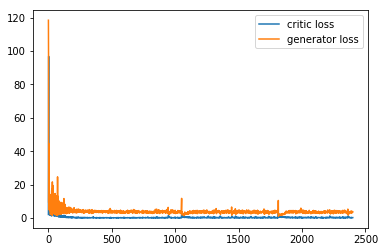

  8%|▊         | 2499/31650 [09:03<1:45:41,  4.60it/s]

step: 2500, D: 0.32237, G: 2.81547


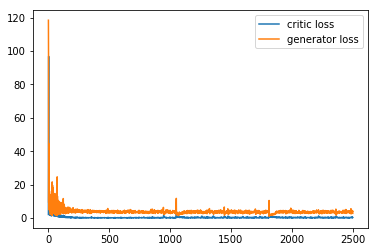

  8%|▊         | 2599/31650 [09:25<1:45:16,  4.60it/s]

step: 2600, D: 0.241713, G: 3.89712


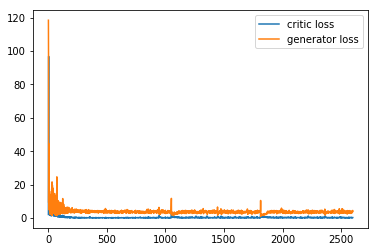

  9%|▊         | 2699/31650 [09:46<1:44:51,  4.60it/s]

step: 2700, D: 0.124174, G: 3.86515


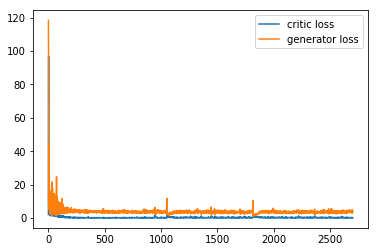

  9%|▉         | 2799/31650 [10:08<1:44:28,  4.60it/s]

step: 2800, D: 0.204768, G: 3.8448


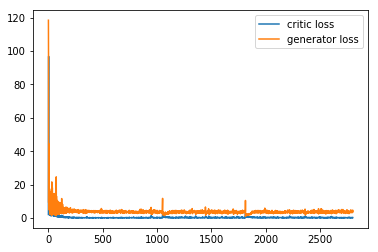

  9%|▉         | 2899/31650 [10:29<1:44:05,  4.60it/s]

step: 2900, D: 0.256909, G: 3.6996


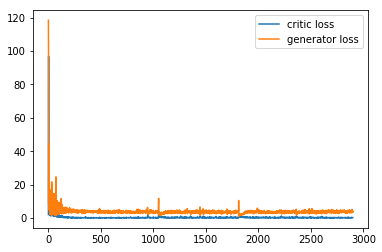

  9%|▉         | 2999/31650 [10:51<1:43:39,  4.61it/s]

step: 3000, D: 0.708171, G: 2.65691


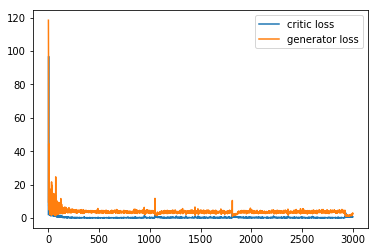

 10%|▉         | 3099/31650 [11:12<1:43:14,  4.61it/s]

step: 3100, D: 0.199644, G: 4.7964


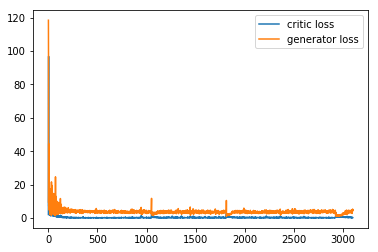

 10%|█         | 3199/31650 [11:34<1:42:52,  4.61it/s]

step: 3200, D: 0.148507, G: 3.75934


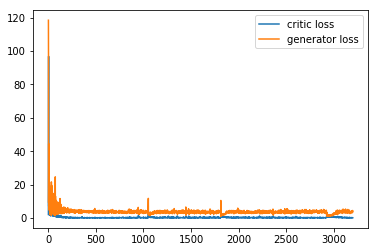

 10%|█         | 3299/31650 [11:55<1:42:27,  4.61it/s]

step: 3300, D: 1.00626, G: 1.50406


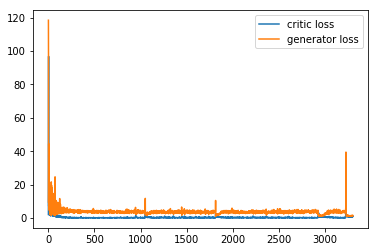

 11%|█         | 3399/31650 [12:16<1:42:04,  4.61it/s]

step: 3400, D: 0.774327, G: 1.13182


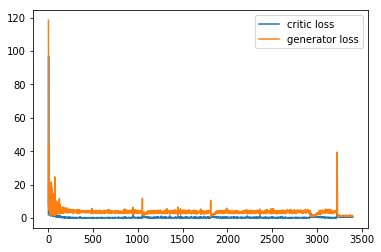

 11%|█         | 3499/31650 [12:38<1:41:42,  4.61it/s]

step: 3500, D: 0.917318, G: 1.31395


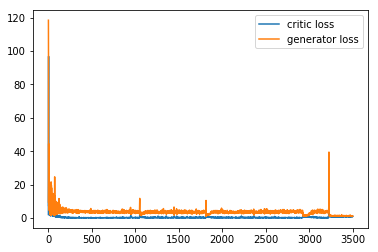

 11%|█▏        | 3599/31650 [12:59<1:41:18,  4.61it/s]

step: 3600, D: 0.983576, G: 1.3486


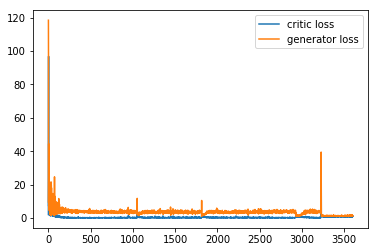

 12%|█▏        | 3699/31650 [13:21<1:40:55,  4.62it/s]

step: 3700, D: 0.742794, G: 1.29807


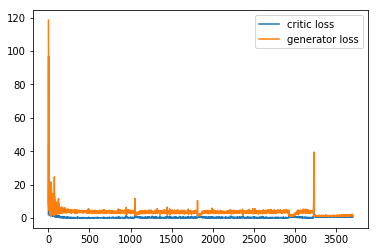

 12%|█▏        | 3799/31650 [13:42<1:40:31,  4.62it/s]

step: 3800, D: 0.432123, G: 3.12178


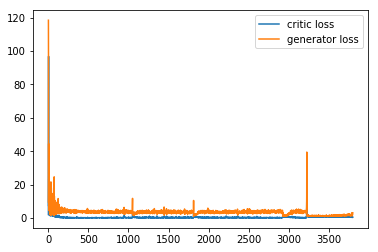

 12%|█▏        | 3899/31650 [14:04<1:40:09,  4.62it/s]

step: 3900, D: 0.696209, G: 2.08924


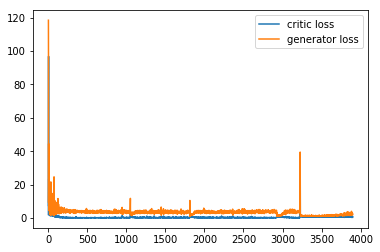

 13%|█▎        | 3999/31650 [14:25<1:39:45,  4.62it/s]

step: 4000, D: 0.349967, G: 3.35756


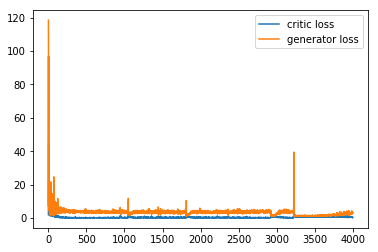

 13%|█▎        | 4099/31650 [14:46<1:39:21,  4.62it/s]

step: 4100, D: 0.243452, G: 2.98472


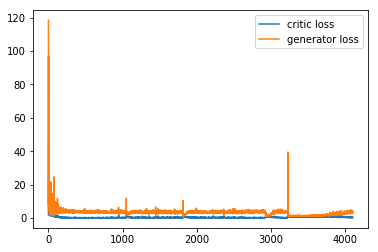

 13%|█▎        | 4199/31650 [15:08<1:38:57,  4.62it/s]

step: 4200, D: 0.33672, G: 2.9896


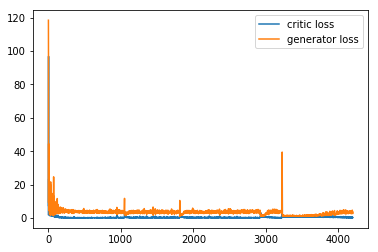

 14%|█▎        | 4299/31650 [15:29<1:38:36,  4.62it/s]

step: 4300, D: 0.44298, G: 2.61646


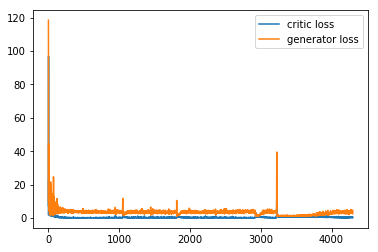

 14%|█▍        | 4399/31650 [15:51<1:38:13,  4.62it/s]

step: 4400, D: 0.289988, G: 3.9132


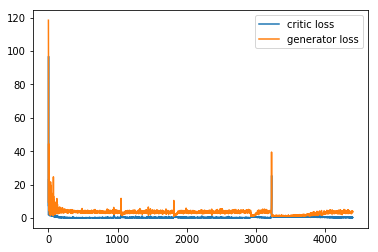

 14%|█▍        | 4499/31650 [16:12<1:37:49,  4.63it/s]

step: 4500, D: 0.327351, G: 3.831


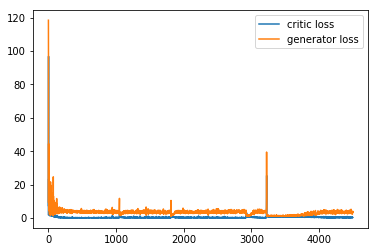

 15%|█▍        | 4599/31650 [16:34<1:37:26,  4.63it/s]

step: 4600, D: 0.241382, G: 3.75666


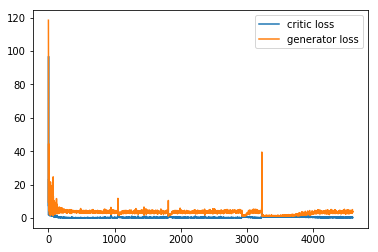

 15%|█▍        | 4699/31650 [16:55<1:37:04,  4.63it/s]

step: 4700, D: 0.864729, G: 0.97154


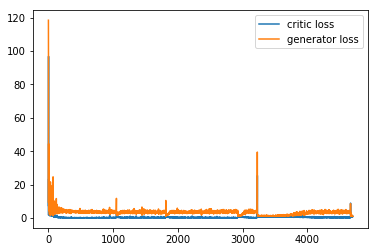

 15%|█▌        | 4799/31650 [17:16<1:36:41,  4.63it/s]

step: 4800, D: 0.90973, G: 1.52126


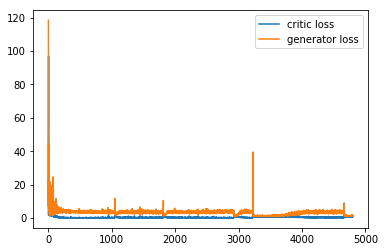

 15%|█▌        | 4899/31650 [17:38<1:36:19,  4.63it/s]

step: 4900, D: 0.49573, G: 3.07887


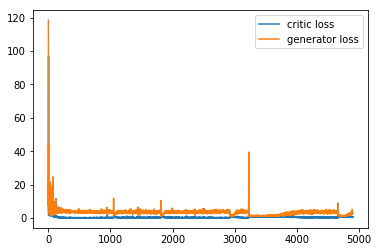

 16%|█▌        | 4999/31650 [17:59<1:35:57,  4.63it/s]

step: 5000, D: 0.420078, G: 2.84152


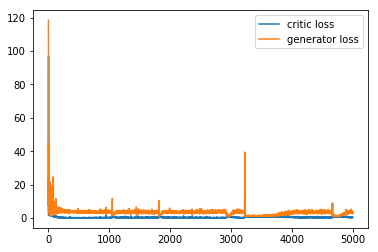

 16%|█▌        | 5099/31650 [18:21<1:35:35,  4.63it/s]

step: 5100, D: 0.258523, G: 3.2256


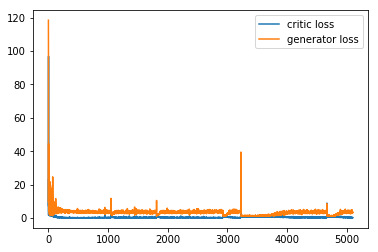

 16%|█▋        | 5199/31650 [18:42<1:35:12,  4.63it/s]

step: 5200, D: 0.221435, G: 2.88472


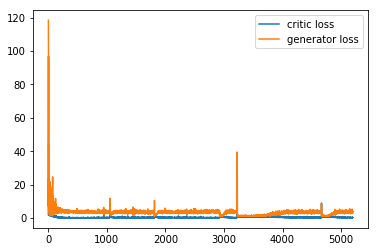

 17%|█▋        | 5299/31650 [19:04<1:34:49,  4.63it/s]

step: 5300, D: 0.17189, G: 4.10719


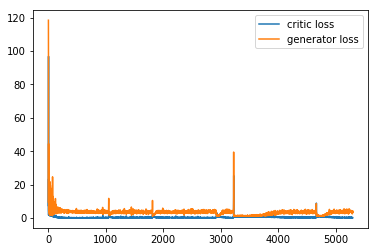

 17%|█▋        | 5399/31650 [19:25<1:34:27,  4.63it/s]

step: 5400, D: 0.392664, G: 3.0154


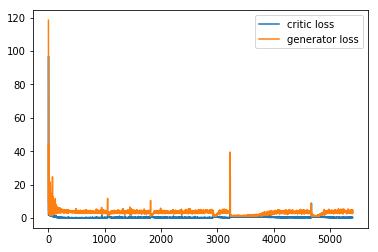

 17%|█▋        | 5499/31650 [19:47<1:34:05,  4.63it/s]

step: 5500, D: 0.314585, G: 4.3292


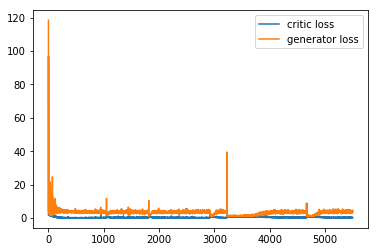

 18%|█▊        | 5599/31650 [20:08<1:33:41,  4.63it/s]

step: 5600, D: 0.316256, G: 3.39141


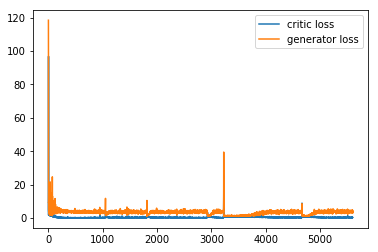

 18%|█▊        | 5699/31650 [20:29<1:33:19,  4.63it/s]

step: 5700, D: 0.307376, G: 2.61346


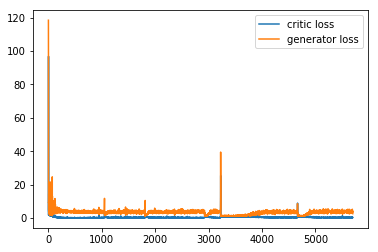

 18%|█▊        | 5799/31650 [20:51<1:32:58,  4.63it/s]

step: 5800, D: 0.288144, G: 2.85234


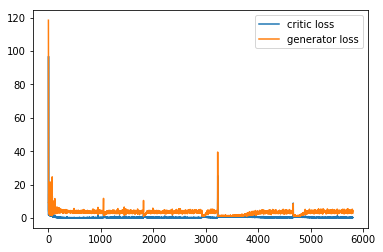

 19%|█▊        | 5899/31650 [21:12<1:32:35,  4.64it/s]

step: 5900, D: 0.234407, G: 3.97295


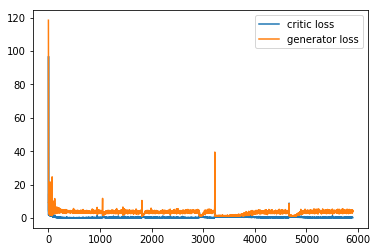

 19%|█▉        | 5999/31650 [21:34<1:32:14,  4.64it/s]

step: 6000, D: 0.419299, G: 2.99857


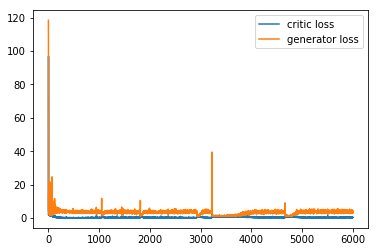

 19%|█▉        | 6099/31650 [21:55<1:31:51,  4.64it/s]

step: 6100, D: 0.234695, G: 3.08713


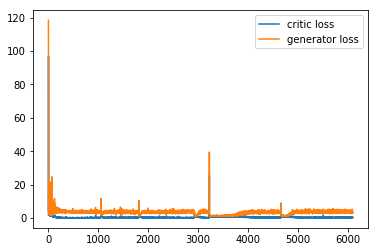

 20%|█▉        | 6199/31650 [22:17<1:31:30,  4.64it/s]

step: 6200, D: 0.254133, G: 3.28139


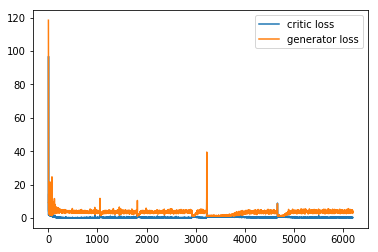

 20%|█▉        | 6299/31650 [22:38<1:31:08,  4.64it/s]

step: 6300, D: 0.351011, G: 3.94538


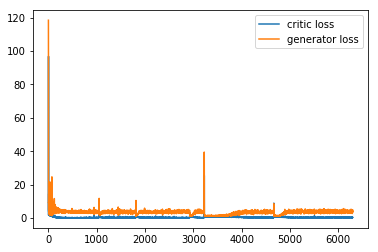

 20%|██        | 6399/31650 [23:00<1:30:45,  4.64it/s]

step: 6400, D: 0.346931, G: 3.53799


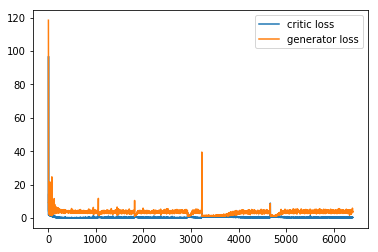

 21%|██        | 6499/31650 [23:21<1:30:23,  4.64it/s]

step: 6500, D: 0.370471, G: 4.03861


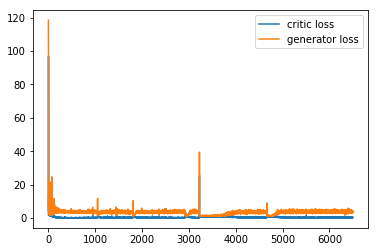

 21%|██        | 6599/31650 [23:43<1:30:02,  4.64it/s]

step: 6600, D: 0.384024, G: 4.31924


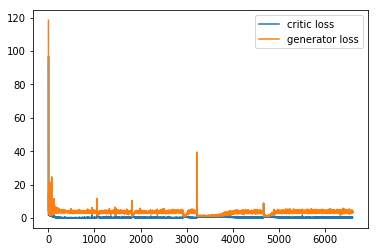

 21%|██        | 6699/31650 [24:04<1:29:40,  4.64it/s]

step: 6700, D: 0.292194, G: 4.18933


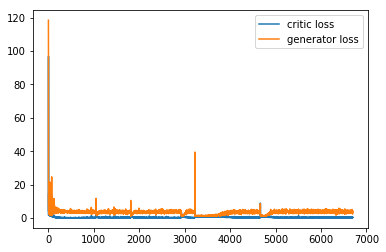

 21%|██▏       | 6799/31650 [24:25<1:29:18,  4.64it/s]

step: 6800, D: 0.237891, G: 3.76369


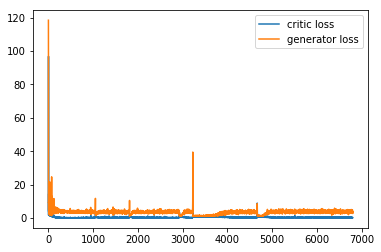

 22%|██▏       | 6899/31650 [24:47<1:28:56,  4.64it/s]

step: 6900, D: 0.655607, G: 2.82829


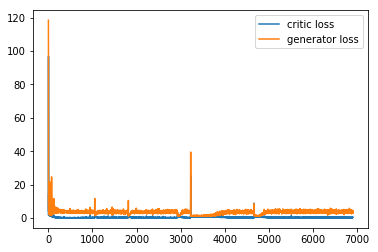

 22%|██▏       | 6999/31650 [25:08<1:28:34,  4.64it/s]

step: 7000, D: 0.236763, G: 3.82479


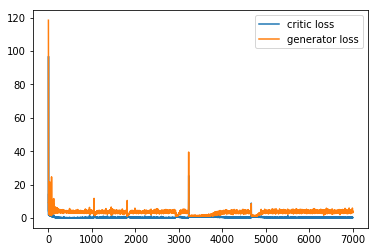

 22%|██▏       | 7099/31650 [25:30<1:28:12,  4.64it/s]

step: 7100, D: 0.256209, G: 4.5445


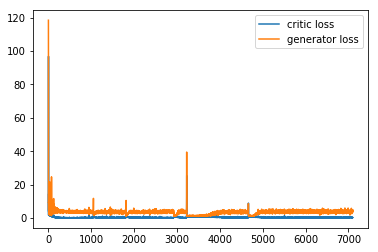

 23%|██▎       | 7199/31650 [25:51<1:27:50,  4.64it/s]

step: 7200, D: 0.23626, G: 3.43895


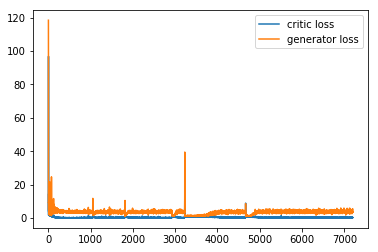

 23%|██▎       | 7299/31650 [26:13<1:27:29,  4.64it/s]

step: 7300, D: 0.175632, G: 3.95678


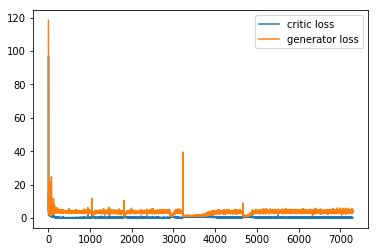

 23%|██▎       | 7399/31650 [26:34<1:27:07,  4.64it/s]

step: 7400, D: 0.204853, G: 4.04606


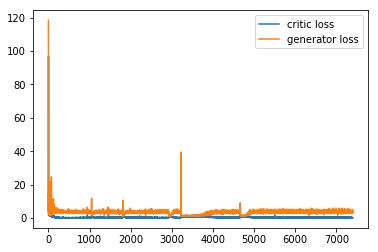

 24%|██▎       | 7499/31650 [26:56<1:26:45,  4.64it/s]

step: 7500, D: 0.370925, G: 4.01491


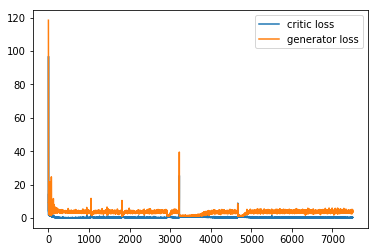

 24%|██▍       | 7599/31650 [27:17<1:26:22,  4.64it/s]

step: 7600, D: 0.20224, G: 2.85792


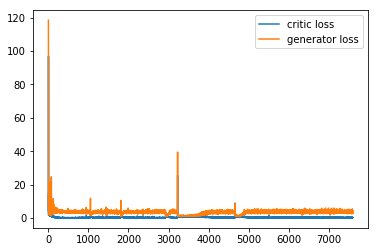

 24%|██▍       | 7699/31650 [27:39<1:26:02,  4.64it/s]

step: 7700, D: 0.224783, G: 4.7579


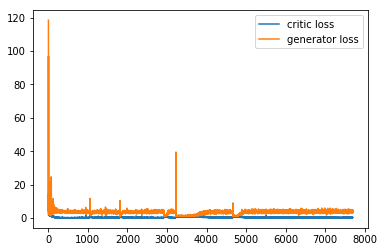

 25%|██▍       | 7799/31650 [28:00<1:25:39,  4.64it/s]

step: 7800, D: 0.204182, G: 3.62017


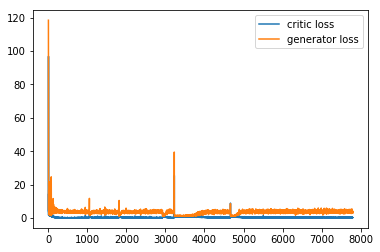

 25%|██▍       | 7899/31650 [28:21<1:25:17,  4.64it/s]

step: 7900, D: 0.287216, G: 3.53228


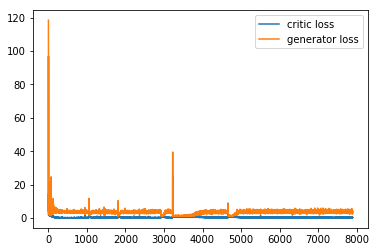

 25%|██▌       | 7999/31650 [28:43<1:24:55,  4.64it/s]

step: 8000, D: 0.382824, G: 4.98657


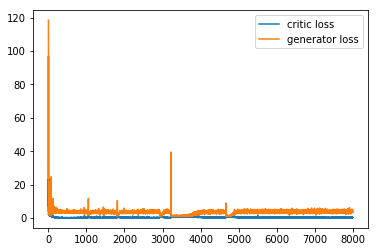

 26%|██▌       | 8099/31650 [29:04<1:24:33,  4.64it/s]

step: 8100, D: 0.786426, G: 2.03688


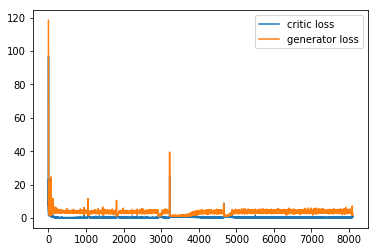

 26%|██▌       | 8199/31650 [29:26<1:24:12,  4.64it/s]

step: 8200, D: 0.393883, G: 3.58037


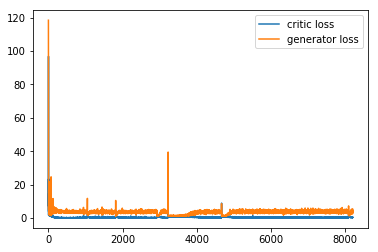

 26%|██▌       | 8299/31650 [29:47<1:23:50,  4.64it/s]

step: 8300, D: 0.327809, G: 3.3168


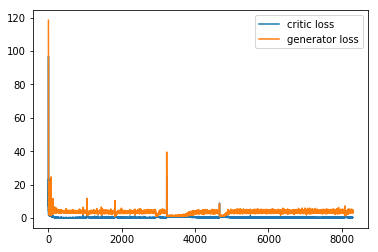

 27%|██▋       | 8399/31650 [30:09<1:23:29,  4.64it/s]

step: 8400, D: 0.331382, G: 3.40121


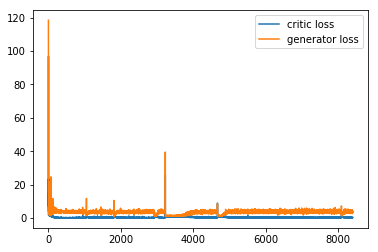

 27%|██▋       | 8499/31650 [30:31<1:23:08,  4.64it/s]

step: 8500, D: 0.292307, G: 3.10084


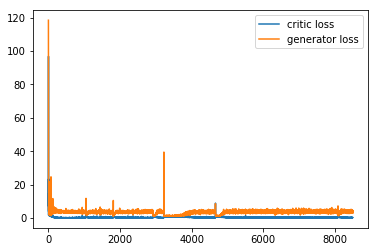

 27%|██▋       | 8599/31650 [30:52<1:22:46,  4.64it/s]

step: 8600, D: 0.278301, G: 4.19689


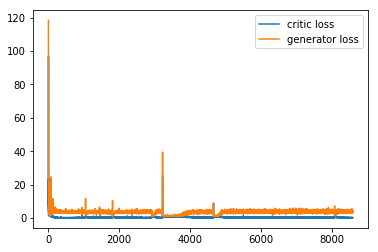

 27%|██▋       | 8699/31650 [31:14<1:22:24,  4.64it/s]

step: 8700, D: 0.240711, G: 4.64499


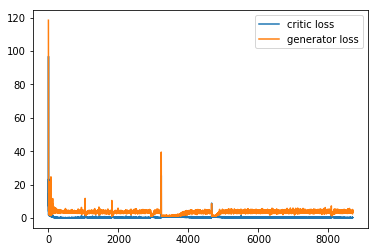

 28%|██▊       | 8799/31650 [31:35<1:22:02,  4.64it/s]

step: 8800, D: 0.317275, G: 3.50985


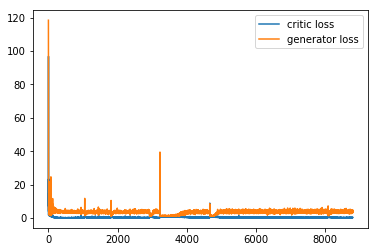

 28%|██▊       | 8899/31650 [31:56<1:21:40,  4.64it/s]

step: 8900, D: 0.203867, G: 3.72509


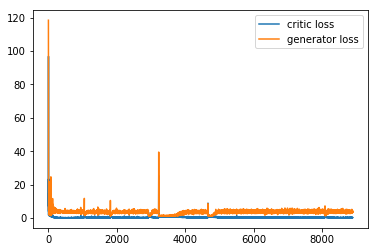

 28%|██▊       | 8999/31650 [32:18<1:21:18,  4.64it/s]

step: 9000, D: 0.253, G: 3.12766


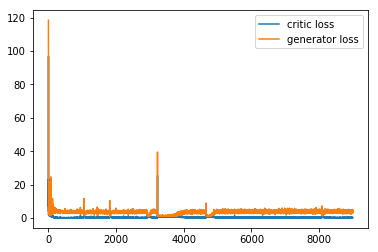

 29%|██▊       | 9099/31650 [32:39<1:20:56,  4.64it/s]

step: 9100, D: 0.310363, G: 3.44243


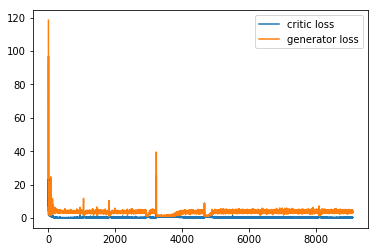

 29%|██▉       | 9199/31650 [33:01<1:20:35,  4.64it/s]

step: 9200, D: 0.235139, G: 3.31553


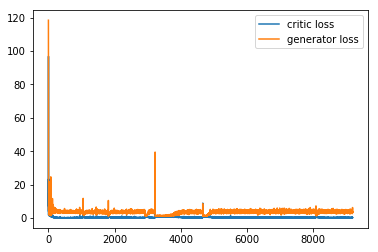

 29%|██▉       | 9299/31650 [33:22<1:20:13,  4.64it/s]

step: 9300, D: 0.207343, G: 3.4394


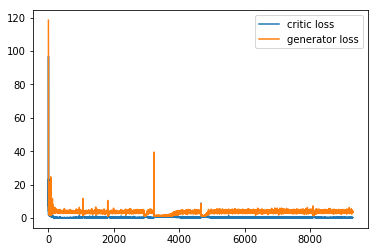

 30%|██▉       | 9399/31650 [33:43<1:19:51,  4.64it/s]

step: 9400, D: 0.447405, G: 4.19479


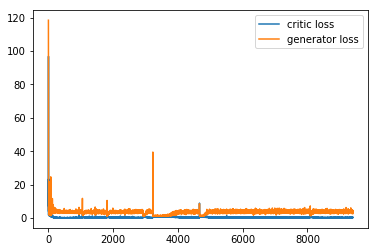

 30%|███       | 9499/31650 [34:05<1:19:30,  4.64it/s]

step: 9500, D: 0.207996, G: 3.61257


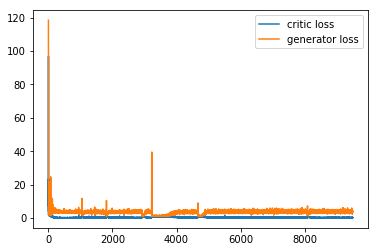

 30%|███       | 9599/31650 [34:26<1:19:08,  4.64it/s]

step: 9600, D: 0.147677, G: 3.27807


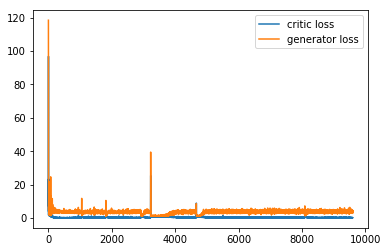

 31%|███       | 9699/31650 [34:48<1:18:46,  4.64it/s]

step: 9700, D: 0.338415, G: 4.0724


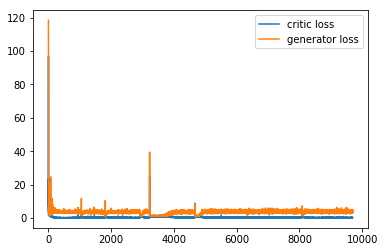

 31%|███       | 9799/31650 [35:09<1:18:24,  4.64it/s]

step: 9800, D: 0.208796, G: 3.89003


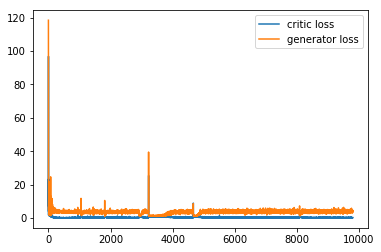

 31%|███▏      | 9899/31650 [35:31<1:18:03,  4.64it/s]

step: 9900, D: 0.199308, G: 3.83126


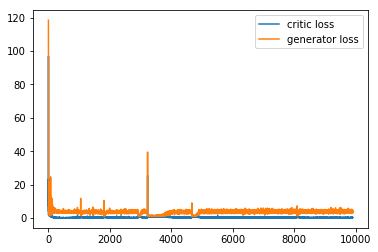

 32%|███▏      | 9999/31650 [35:52<1:17:41,  4.64it/s]

step: 10000, D: 0.277062, G: 4.64811


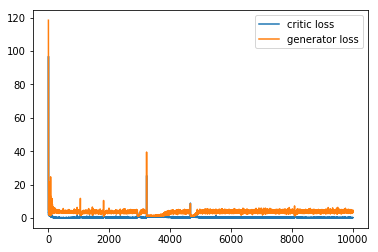

 32%|███▏      | 10099/31650 [36:14<1:17:19,  4.64it/s]

step: 10100, D: 0.173643, G: 3.85042


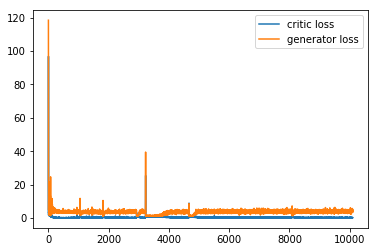

 32%|███▏      | 10199/31650 [36:35<1:16:57,  4.65it/s]

step: 10200, D: 0.260979, G: 3.60479


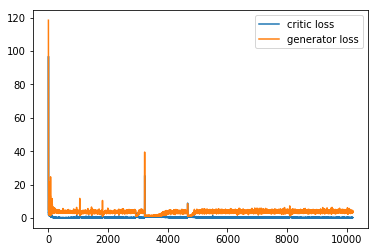

 33%|███▎      | 10299/31650 [36:57<1:16:36,  4.65it/s]

step: 10300, D: 0.232577, G: 3.40454


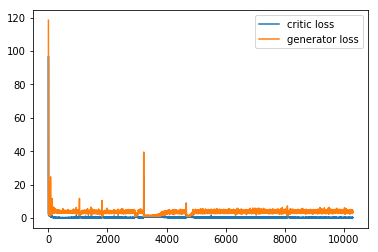

 33%|███▎      | 10399/31650 [37:18<1:16:14,  4.65it/s]

step: 10400, D: 0.499888, G: 2.66839


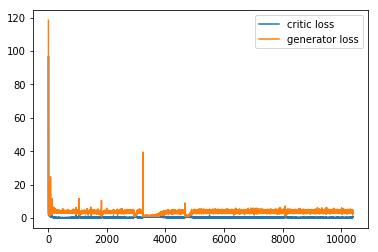

 33%|███▎      | 10499/31650 [37:39<1:15:52,  4.65it/s]

step: 10500, D: 0.197901, G: 4.26673


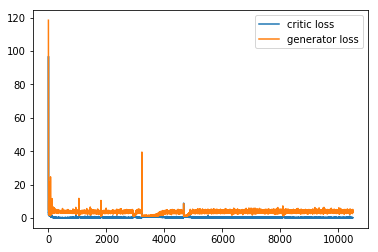

 33%|███▎      | 10599/31650 [38:01<1:15:30,  4.65it/s]

step: 10600, D: 0.164723, G: 4.40723


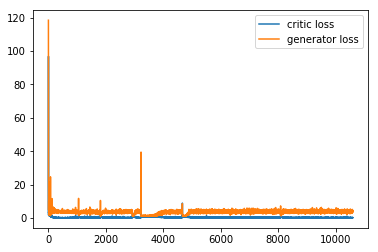

 34%|███▍      | 10699/31650 [38:22<1:15:09,  4.65it/s]

step: 10700, D: 0.254812, G: 2.73546


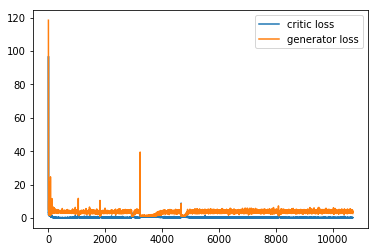

 34%|███▍      | 10799/31650 [38:44<1:14:47,  4.65it/s]

step: 10800, D: 0.15474, G: 3.85169


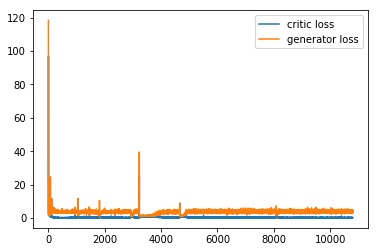

 34%|███▍      | 10899/31650 [39:05<1:14:25,  4.65it/s]

step: 10900, D: 0.215691, G: 3.75024


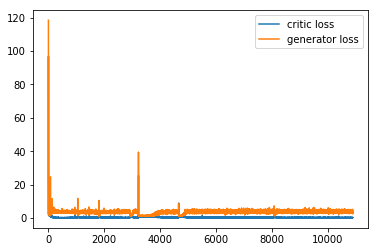

 35%|███▍      | 10999/31650 [39:27<1:14:04,  4.65it/s]

step: 11000, D: 0.230139, G: 3.24387


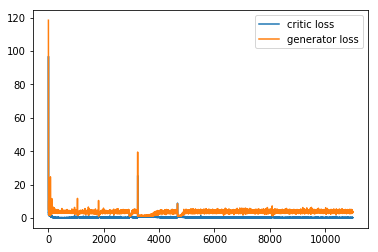

 35%|███▌      | 11099/31650 [39:48<1:13:43,  4.65it/s]

step: 11100, D: 0.234339, G: 3.75318


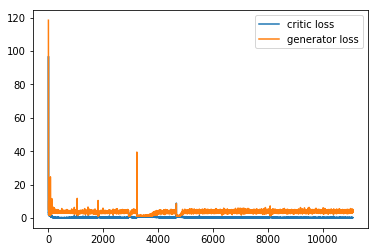

 35%|███▌      | 11199/31650 [40:10<1:13:21,  4.65it/s]

step: 11200, D: 0.431902, G: 2.1336


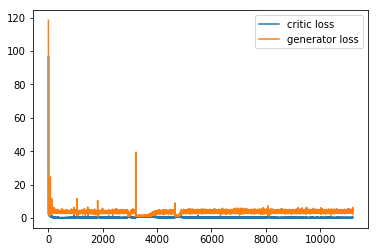

 36%|███▌      | 11299/31650 [40:31<1:12:59,  4.65it/s]

step: 11300, D: 0.159014, G: 3.49397


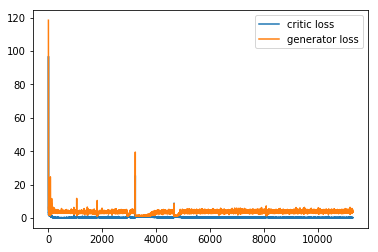

 36%|███▌      | 11399/31650 [40:53<1:12:38,  4.65it/s]

step: 11400, D: 0.206496, G: 4.05594


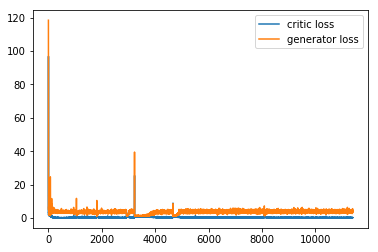

 36%|███▋      | 11499/31650 [41:14<1:12:16,  4.65it/s]

step: 11500, D: 0.198659, G: 4.25877


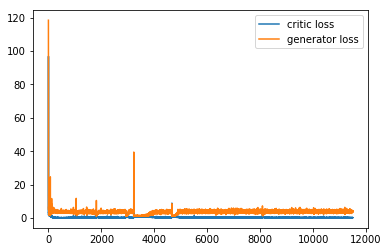

 37%|███▋      | 11599/31650 [41:35<1:11:54,  4.65it/s]

step: 11600, D: 0.23383, G: 4.49151


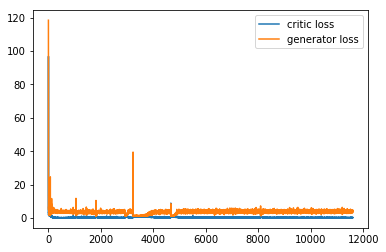

 37%|███▋      | 11699/31650 [41:57<1:11:32,  4.65it/s]

step: 11700, D: 0.185522, G: 4.11599


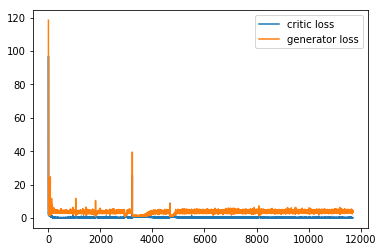

 37%|███▋      | 11799/31650 [42:18<1:11:11,  4.65it/s]

step: 11800, D: 0.125128, G: 3.53881


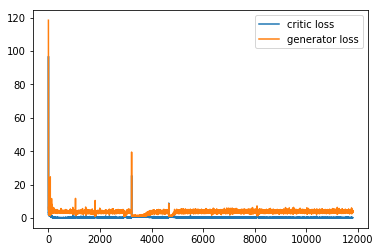

 38%|███▊      | 11899/31650 [42:40<1:10:49,  4.65it/s]

step: 11900, D: 0.188676, G: 3.79618


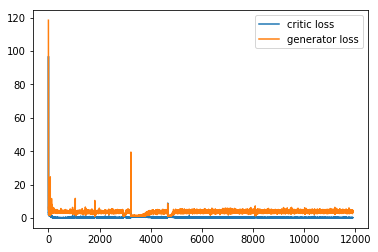

 38%|███▊      | 11999/31650 [43:01<1:10:27,  4.65it/s]

step: 12000, D: 0.391146, G: 2.78346


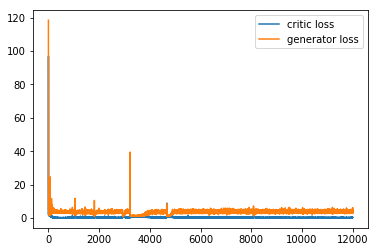

 38%|███▊      | 12099/31650 [43:22<1:10:06,  4.65it/s]

step: 12100, D: 0.168749, G: 3.60546


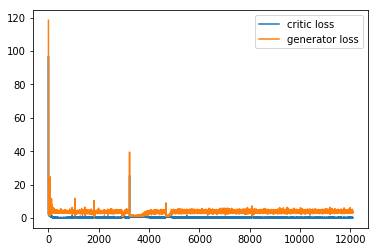

 38%|███▊      | 12117/31650 [43:27<1:10:04,  4.65it/s]

KeyboardInterrupt: 

In [16]:
train(steps=total_steps, batch_size=BATCH_SIZE, sample_interval=100, hist_interval=100)